### Import Modules and Python Functions

In [1]:
import os
import numpy as np
import pandas as pd
import yaml
with open('../python/variables.yaml') as info:
    VARS = yaml.load(info, Loader=yaml.FullLoader)

# visualization modules
import seaborn as sns; sns.set(style="darkgrid")
import matplotlib.pyplot as plt
from random import randint
from pylab import rcParams

### Import Variables

In [2]:
# Events
events_csv = VARS['EVENTS_CSV']
events_cols_all = VARS['EVENTS_COLS_ALL']
events_cols_select = VARS['EVENTS_COLS_SELECT']

# Mentions
mentions_csv = VARS['MENTIONS_CSV']
mentions_cols_all = VARS['MENTIONS_COLS_ALL']
mentions_cols_select = VARS['MENTIONS_COLS_SELECT']

# Pilot
cameo_verbs = VARS['CAMEO_VERBS']
cameo_quadclass = VARS['CAMEO_QUADCLASS']
select_countries_60 = VARS['PILOT_COUNTRIES_IOS2']

### Define Reusable Python Functions

In [3]:
def get_var_percentages(df: pd, target_col: str, sort=False) -> pd:
    """Get Percentage of Column Values in Target Column of Cleaned GDELT Data
    :param df: dataframe of cleaned data
    :param target_col: column name of variable of interest
    :rtype: dataframe
    :return: dataframe
    """

    # Create a sub-dataframe to group GLOBALEVENTID by Target Column
    grouped_df = df[['GLOBALEVENTID', target_col]].groupby(target_col).count()
    
    # Get variable percentage                                                                
    grouped_df['%'] = (grouped_df['GLOBALEVENTID'] / grouped_df['GLOBALEVENTID'].sum()) * 100
    
    if sort==True:
        grouped_df = grouped_df.sort_values(by='%', ascending=False).reset_index()
    
    return grouped_df

In [4]:
def plot_piechart(df: pd, target_cols: str, pie_title: str, save_png: str) -> pd:
    """ Create colorful pie chart showing percent of events by variable label
    :param df: dataframe created via the get_var_percentages() function
    :param target_cols: target column in the get_var_percentages() function
    :param pie_title: target column string for pie chart title
    :param save_png: string based on the target column for storing png
    """
    # Create color list for pie chart visualization
    labels = df[target_cols]
    colors = []
    for i in range(len(labels)):
        colors.append('#%06X' % randint(0, 0xFFFFFF))
    
    if len(np.unique(labels)) > 10:
        rcParams['figure.figsize'] = 30,30
    else:
        rcParams['figure.figsize'] = 8,8

    # Plot
    plt.pie(df['%'], colors=colors, labels=labels, autopct='%1.1f%%')
    plt.title('Percentage of Events by '+ pie_title)
    plt.savefig('../images/' + save_png + '.png', dpi=300)
    plt.show()

### Import Data

In [5]:
# Store dataframe globally
%store -r cleaned_merged_df
print(cleaned_merged_df.shape)
cleaned_merged_df.head()

(1267, 19)


,GLOBALEVENTID,SQLDATE,EventCode,EventRootCode,QuadClass,GoldsteinScale,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_Lat,ActionGeo_Long,SOURCEURL,EventTimeDate,MentionTimeDate,Confidence,MentionDocTone,DaysBetween,EventRootCodeString,QuadClassString
0,972238884,20200301,20,2,1,3.0,4,"Canberra, Australian Capital Territory, Australia",AS,-35.2833,149.2170,https://www.aninews.in/news/world/asia/china-a...,2021-03-01 20:45:00,2021-03-01 20:45:00,20.0,-6.529210,0.0,APPEAL,Verbal Cooperation
1,972238885,20200301,20,2,1,3.0,4,"Beijing, Beijing, China",CH,39.9289,116.3880,https://www.aninews.in/news/world/asia/china-a...,2021-03-01 20:45:00,2021-03-01 20:45:00,20.0,-6.529210,0.0,APPEAL,Verbal Cooperation
2,972238886,20200301,20,2,1,3.0,4,"Beijing, Beijing, China",CH,39.9289,116.3880,https://www.aninews.in/news/world/asia/china-a...,2021-03-01 20:45:00,2021-03-01 20:45:00,60.0,-6.529210,0.0,APPEAL,Verbal Cooperation
3,972238887,20200301,111,11,3,-2.0,4,"Mumbai, Maharashtra, India",IN,18.9750,72.8258,https://www.techshout.com/security/2021/01/chi...,2021-03-01 20:45:00,2021-03-01 20:45:00,40.0,-4.385965,0.0,DISAPPROVE,Verbal Conflict
4,972238888,20200301,110,11,3,-2.0,4,"Mumbai, Maharashtra, India",IN,18.9750,72.8258,https://www.techshout.com/security/2021/01/chi...,2021-03-01 20:45:00,2021-03-01 20:45:00,40.0,-4.385965,0.0,DISAPPROVE,Verbal Conflict


## Assess Metrics by Country

### Question 1: Can the country's full name column within the GDELT data be used in the drop-down list?

In [6]:
# Create a sub-dataframe to show ActionGeo_FullName and ActionGeo_CountryCode
countries = cleaned_merged_df[['ActionGeo_CountryCode', 'ActionGeo_FullName']].sort_values(by='ActionGeo_CountryCode')
countries = countries.drop_duplicates()
print(len(countries))
countries

289


,ActionGeo_CountryCode,ActionGeo_FullName
948,AC,Antigua And Barbuda
184,AE,"Dubai, Dubayy, United Arab Emirates"
196,AJ,"Artsakh, Azerbaijan (general), Azerbaijan"
174,AO,"Luanda, Luanda, Angola"
417,AR,Argentina
...,...,...
171,VE,"Caracas, Distrito Federal, Venezuela"
134,YM,Yemen
472,YM,"Jawf, Abyan, Yemen"
1255,ZI,"Salisbury, Mashonaland East, Zimbabwe"


Observations: Since there are not 289 countries, it's best to assess the number of Countries within this dataset is to look at country codes, then count the number of full name options per country code

In [7]:
# Create a derivative dataframe to show count ActionGeo_CountryCode and count ActionGeo_FullName per code
countries_codes = countries.groupby('ActionGeo_CountryCode').count().sort_values(by='ActionGeo_CountryCode')
countries_codes = countries_codes.drop_duplicates()
print(len(countries_codes))
countries_codes

13


,ActionGeo_FullName
ActionGeo_CountryCode,
AC,1
AS,3
BF,2
BM,4
CA,9
CH,10
IN,17
IR,5
NI,12


#### Conclusions: The full name reference of each country is highly variable (ie. within this subset of data, US has 104 full name variations). Thus, for the drop-down selection portion of the dashboard, the country IOS2 code will be used.

### Question 2: What is the total count of events by the most granular-level of time? By country?

/Users/emily-work/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


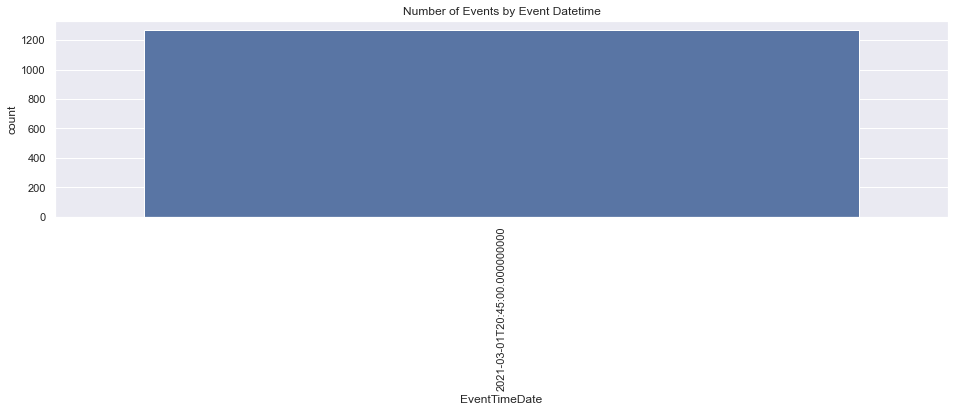

In [8]:
# Create a bar graph to show distribution of incidences of maternal death by region
fig, ax = plt.subplots(figsize=(16, 4))
plt.xticks(rotation='vertical')
plt.grid(True)
fig.subplots_adjust(bottom=0.2)
sns.countplot(cleaned_merged_df['EventTimeDate'])
plt.title('Number of Events by Event Datetime')
plt.show()

Observations: This needs to be assessed with more data. This exploration is briefly placed on hold until after the meeting with the Data Engineers to establish the most efficient pipeline to import GDELT's data (02 March 2021)

#### By Country

/Users/emily-work/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


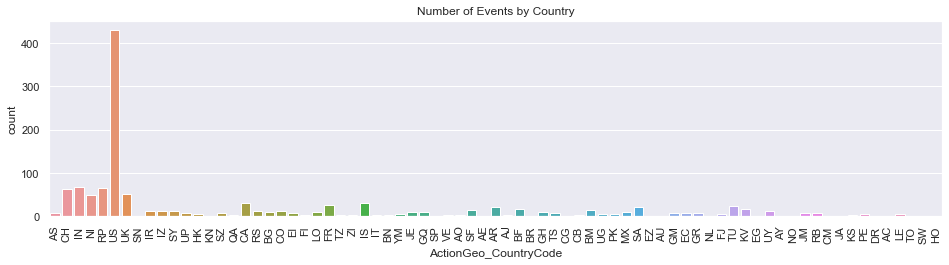

In [9]:
# Create a bar graph to show distribution of incidences of maternal death by region
fig, ax = plt.subplots(figsize=(16, 4))
plt.xticks(rotation='vertical')
plt.grid(True)
fig.subplots_adjust(bottom=0.2)
sns.countplot(cleaned_merged_df['ActionGeo_CountryCode'])
plt.title('Number of Events by Country')
plt.show()

Observations: While this needs to be assessed with more data, it appears that the US has substantially more records when compared to all other countries within this dataset. This exploration is briefly placed on hold until after the meeting with the Data Engineers to establish the most efficient pipeline to import GDELT's data (02 March 2021)

### Question 2: What is the Percentage of Events per QuadClass? What is the MODE Confidence and Tone per QuadClass?

#### Percentage of Events by QuadClass

In [10]:
# Create a sub-dataframe to group GLOBALEVENTID by QuadClass
quadclass = get_var_percentages(cleaned_merged_df, 'QuadClassString', sort=True)
quadclass

,QuadClassString,GLOBALEVENTID,%
0,Verbal Cooperation,781,61.641673
1,Material Conflict,171,13.496448
2,Material Cooperation,160,12.628256
3,Verbal Conflict,155,12.233623


#### Visualize

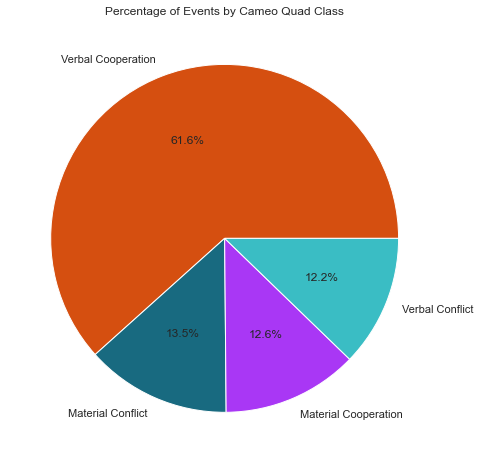

In [11]:
plot_piechart(quadclass, 'QuadClassString', 'Cameo Quad Class', 'cameo_quadclass_percentages')

Observations: While this needs to be assessed with more data, it does appear that QuadClass 1, meaning Verbal Cooperation, is the most prevelant, followed by QuadClass 4, Material Cooperation. However, is based on the previous section, it would be worthwhile to remove US-associated events and re-assess. This exploration is briefly placed on hold until after the meeting with the Data Engineers to establish the most efficient pipeline to import GDELT's data (02 March 2021)

In [12]:
# Create a sub-dataframe to group GLOBALEVENTID by QuadClass without US 
non_us_df = cleaned_merged_df.loc[ cleaned_merged_df['ActionGeo_CountryCode'] != 'US' ]
non_us_quadclass = get_var_percentages(non_us_df, 'QuadClass')
non_us_quadclass

,GLOBALEVENTID,%
QuadClass,,
1,523,62.485066
2,90,10.752688
3,96,11.469534
4,128,15.292712


Observations: The propotions seemed to have remained roughly the same with a slight increase in QuadClass 1 and 4 and slight decreases in QuadClass 2 and 3. This exploration is briefly placed on hold until after the meeting with the Data Engineers to establish the most efficient pipeline to import GDELT's data (02 March 2021)

#### By Country

#### Mode of Confidence and MentionDocTone Values by QuadClass

In [13]:
# Create a sub-dataframe to group GLOBALEVENTID by QuadClass
quadclass_modes = cleaned_merged_df[['QuadClass','Confidence','MentionDocTone']
                                   ].groupby('QuadClass').agg(lambda x: pd.Series.mode(x)[0])
quadclass_modes

,Confidence,MentionDocTone
QuadClass,,
1,20.0,-4.883721
2,20.0,-4.848485
3,40.0,-2.465166
4,20.0,-5.102041


Observations: The propotions seemed to have remained roughly the same with a slight increase in QuadClass 1 and 4 and slight decreases in QuadClass 2 and 3. This exploration is briefly placed on hold until after the meeting with the Data Engineers to establish the most efficient pipeline to import GDELT's data (02 March 2021)

### Question 2: What is the Percentage of Events per EventRootCode? What is the MODE Confidence and Tone per EventRootCode?

In [14]:
# Create a sub-dataframe to group GLOBALEVENTID by EventRootCode
cameoaction = get_var_percentages(cleaned_merged_df, 'EventRootCodeString', sort=True)
cameoaction

,EventRootCodeString,GLOBALEVENTID,%
0,CONSULT,293,23.125493
1,ENGAGE IN DIPLOMATIC COOPERATION,166,13.101815
2,MAKE PUBLIC STATEMENT,164,12.943962
3,APPEAL,94,7.419100
4,FIGHT,72,5.682715
5,DISAPPROVE,67,5.288082
6,EXPRESS INTENT TO COOPERATE,64,5.051302
7,PROVIDE AID,59,4.656669
8,COERCE,55,4.340963
9,YIELD,51,4.025257


#### Visualize

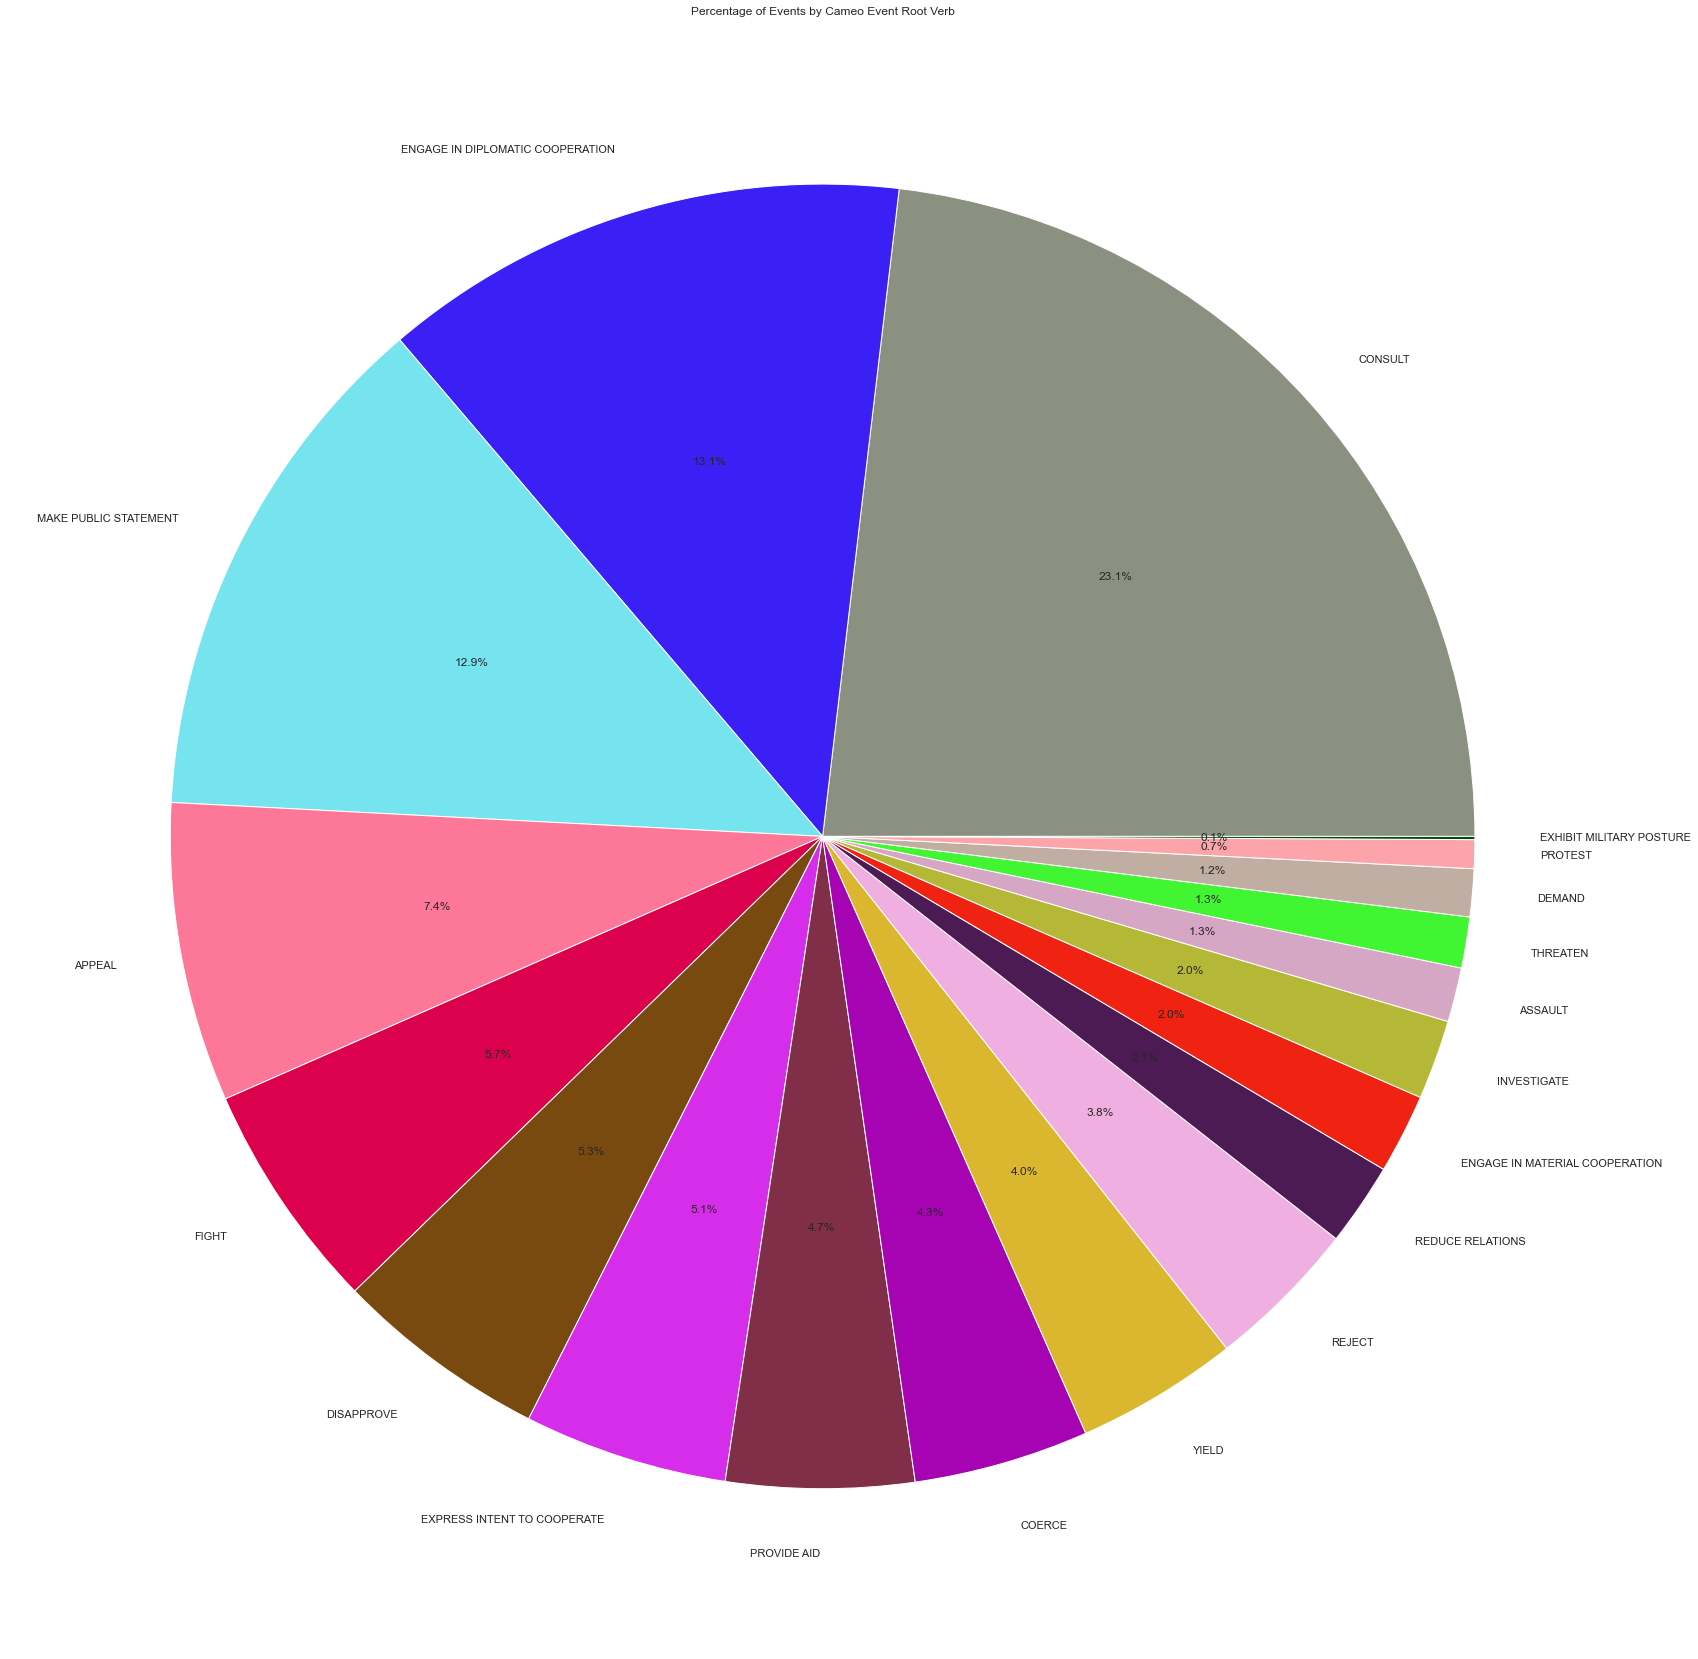

In [15]:
plot_piechart(cameoaction, 'EventRootCodeString', 'Cameo Event Root Verb', 'cameo_verb_percentages')

Observations: This exploration is briefly placed on hold until after the meeting with the Data Engineers to establish the most efficient pipeline to import GDELT's data (02 March 2021)

### Question 3: What is the Count of EventRootCodes by QuadClass? (ie. does is match the documentation?)

In [16]:
cleaned_merged_df.columns

Index(['GLOBALEVENTID', 'SQLDATE', 'EventCode', 'EventRootCode', 'QuadClass',
       'GoldsteinScale', 'ActionGeo_Type', 'ActionGeo_FullName',
       'ActionGeo_CountryCode', 'ActionGeo_Lat', 'ActionGeo_Long', 'SOURCEURL',
       'EventTimeDate', 'MentionTimeDate', 'Confidence', 'MentionDocTone',
       'DaysBetween', 'EventRootCodeString', 'QuadClassString'],
      dtype='object')

In [17]:
quadclass_events = cleaned_merged_df[['GLOBALEVENTID','QuadClass','QuadClassString','EventRootCodeString']].groupby(['QuadClass','QuadClassString','EventRootCodeString']).count()
print(quadclass_events.shape)
quadclass_events

(19, 1)


GLOBALEVENTID
QuadClass QuadClassString      EventRootCodeString                            
1         Verbal Cooperation   APPEAL                                       94
                               CONSULT                                     293
                               ENGAGE IN DIPLOMATIC COOPERATION            166
                               EXPRESS INTENT TO COOPERATE                  64
                               MAKE PUBLIC STATEMENT                       164
2         Material Cooperation ENGAGE IN MATERIAL COOPERATION               25
                               INVESTIGATE                                  25
                               PROVIDE AID                                  59
                               YIELD                                        51
3         Verbal Conflict      DEMAND                                       15
                               DISAPPROVE                                   67
                               PROTEST                                       9
                               REJECT                                       48
                               THREATEN                                     16
4         Material Conflict    ASSAULT                                      17
                               COERCE                                       55
                               EXHIBIT MILITARY POSTURE                      1
                               FIGHT                                        72
                               REDUCE RELATIONS                             26